# Group 19: Phase 1 - Cats vs Dogs Detector (CaDoD)

## Team Members

We are a group of 4 members: 

Aishwarya Sinhasane - avsinhas@iu.edu (In picture, Left top) 

Himanshu Joshi - hsjoshi@iu.edu (In picture, Right bottom) 

Sreelaxmi Chakkadath - schakkad@iu.edu (In picture, Left bottom) 

Sumitha Vellinalur Thattai - svtranga@iu.edu (In picture, Right top) 



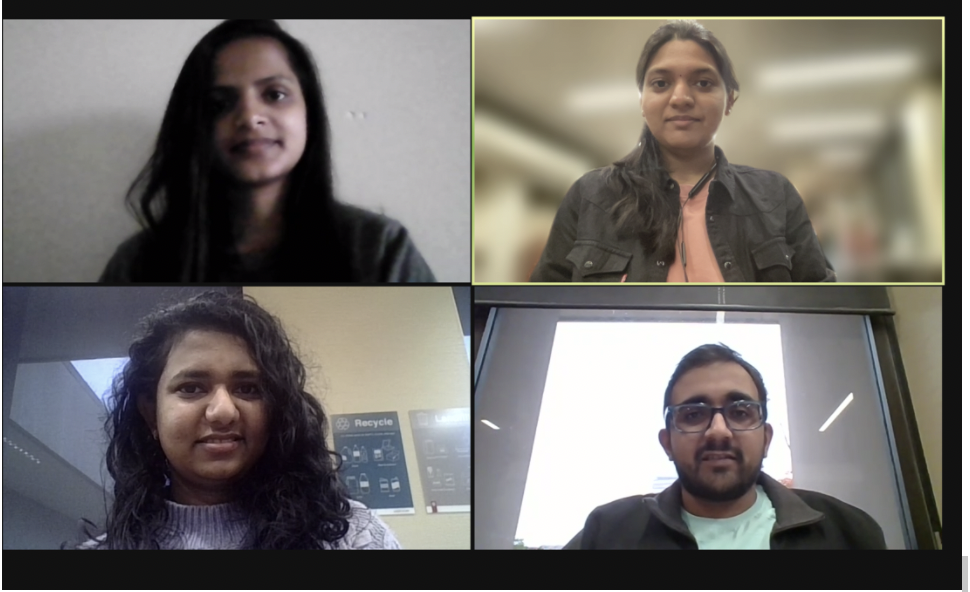


## Project Abstract

Object detection, one of the basic tasks of computer vision, deals with classifying the image based on its content. In recent years, the approach of object detection has evolved rapidly and is being embraced in all fields ranging from healthcare to automotive industries. 

The objective of our project is to classify images as either dogs or cats. Additionally, we also plan to find where the cat/dog is in the image. Although the task is simple to human eyes, computers find it hard to distinguish between images because of a plethora of factors including cluttered background, illumination conditions, deformations, occlusions among several others. We plan to build an end-to-end machine learning model which will help computers differentiate between cat and dog images with better accuracy. 

The data that we plan to use is the CaDoD Kaggle data set. It contains a total of ~13k images of dogs and cats. We have used Stochastic Gradient Descent, Adaboost, and Gradient boosting to predict the image class. Gradient boosting model gives this highest accuracy and henceforth will be used as our baseline model. Furthermore, linear regression was used for the prediction of the position of cats and dogs

Accuracy and Mean F1 score (harmonic mean of recall and precision) are used as evaluation parameters

Furthermore, we plan to improve the accuracy by implementing a CNN for classifying images and using RIdge/Lasso regression for boundary prediction. In addition to this, we plan to tune the hyperparameter by using GridsearchCV/RandomsearchCV

## Project Meta Data

We have completed the following task this week: 

- Data Preprocessing – Image Rescaling and Augmentation 

- Built SGD classifier, Adaboost, and Gradient boost for image classification 

- Built linear regression model for boundary detection 

- Compare the performance of the above models using Accuracy and F1 score and chose the baseline model 

- Implemented homegrown logistic regression 


## Data Description


The data we plan to use is the Kaggle data set. We will be using two files – one for image and the other for boundary: 

The images are taken from the cadod.tar.gz 

The boundary information of the images is from cadod.csv file 

- There are about ~13k images in the data set. There is a good balance of classes with ~6.8K cat images and ~6.1K dog images in the data set. 

Image information (cadod.tar.gz): 

- There are ~13K images of various sizes and aspect ratios. Majority of the images are of 512 X 384 size 

- All the images are in RGB scale  

- The boundaries of the images are stored in the cadod.csv file 

Attributes of the Boundary File (cadod.csv): 

- This has information about the image box coordinates 

- There are about 20 features in this data set 

-15 numerical features 

    - This includes the image ID, the coordinates of the boundary boxes, and also the normalized coordinates of the boundary boxes 

-5 categorical features 

    -This gives information about the occlusion, depiction, truncation, etc. 

## Task

The following are the end-to-end task to achieve the results: 

- Image pre-processing (Rescaling and Augmentation) 

- Use SKlearn packages to build SGD Classifier, Adaboost and Gradientboost 

- Build a linear regression for box detection 

- Implement a homegrown logistic regression model 

Since the data set is very large, we have carried out the above tasks were carried out only in a subset of data. Hence the results will be only directional and not accurate 

In [3]:
from collections import Counter
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
import tarfile
from tqdm import tqdm
import warnings
import seaborn as sns
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Import Data

### Unarchive data

In [4]:
def extract_tar(file, path):
    """
    function to extract tar.gz files to specified location
    
    Args:
        file (str): path where the file is located
        path (str): path where you want to extract
    """
    with tarfile.open(file) as tar:
        files_extracted = 0
        for member in tqdm(tar.getmembers()):
            if os.path.isfile(path + member.name[1:]):
                continue
            else:
                tar.extract(member, path)
                files_extracted += 1
        tar.close()
        if files_extracted < 3:
            print('Files already exist')

In [5]:
path = 'images/'

extract_tar('cadod.tar.gz', path)

100%|██████████| 25936/25936 [00:00<00:00, 367609.83it/s]

Files already exist


### Load bounding box meta data

In [6]:
df = pd.read_csv('cadod.csv')

In [7]:
df.head()

ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  0000b9fcba019d36  xclick  /m/0bt9lr           1  0.165000  0.903750   
1  0000cb13febe0138  xclick  /m/0bt9lr           1  0.000000  0.651875   
2  0005a9520eb22c19  xclick  /m/0bt9lr           1  0.094167  0.611667   
3  0006303f02219b07  xclick  /m/0bt9lr           1  0.000000  0.999219   
4  00064d23bf997652  xclick  /m/0bt9lr           1  0.240938  0.906183   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.268333  0.998333           1            1  ...            0         0   
1  0.000000  0.999062           1            1  ...            0         0   
2  0.055626  0.998736           1            1  ...            0         0   
3  0.000000  0.998824           1            1  ...            0         0   
4  0.000000  0.694286           0            0  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.636250  0.903750  0.748750  0.165000  0.268333  0.506667  0.998333   
1  0.312500  0.000000  0.317500  0.651875  0.000000  0.410882  0.999062   
2  0.487500  0.611667  0.243333  0.094167  0.055626  0.226296  0.998736   
3  0.508594  0.999219  0.000000  0.478906  0.000000  0.375294  0.720000   
4  0.678038  0.906183  0.240938  0.522388  0.000000  0.370000  0.424286   

   XClick4Y  
0  0.661667  
1  0.999062  
2  0.305942  
3  0.998824  
4  0.694286  

[5 rows x 21 columns]

# Exploratory Data Analysis

## Statistics

In [8]:
print(f"There are a total of {len(glob.glob1(path, '*.jpg'))} images")

There are a total of 12966 images


In [9]:
print(f"The total size is {os.path.getsize(path)/1000} MB")

The total size is 830.016 MB


In [10]:
df.shape

(12966, 21)

Replace `LabelName` with human readable labels

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12966 entries, 0 to 12965
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ImageID      12966 non-null  object 
 1   Source       12966 non-null  object 
 2   LabelName    12966 non-null  object 
 3   Confidence   12966 non-null  int64  
 4   XMin         12966 non-null  float64
 5   XMax         12966 non-null  float64
 6   YMin         12966 non-null  float64
 7   YMax         12966 non-null  float64
 8   IsOccluded   12966 non-null  int64  
 9   IsTruncated  12966 non-null  int64  
 10  IsGroupOf    12966 non-null  int64  
 11  IsDepiction  12966 non-null  int64  
 12  IsInside     12966 non-null  int64  
 13  XClick1X     12966 non-null  float64
 14  XClick2X     12966 non-null  float64
 15  XClick3X     12966 non-null  float64
 16  XClick4X     12966 non-null  float64
 17  XClick1Y     12966 non-null  float64
 18  XClick2Y     12966 non-null  float64
 19  XCli

In [12]:
df.LabelName.replace({'/m/01yrx':'cat', '/m/0bt9lr':'dog'}, inplace=True)

In [13]:
df.isnull().sum()

ImageID        0
Source         0
LabelName      0
Confidence     0
XMin           0
XMax           0
YMin           0
YMax           0
IsOccluded     0
IsTruncated    0
IsGroupOf      0
IsDepiction    0
IsInside       0
XClick1X       0
XClick2X       0
XClick3X       0
XClick4X       0
XClick1Y       0
XClick2Y       0
XClick3Y       0
XClick4Y       0
dtype: int64

In [14]:
df.LabelName.value_counts()

dog    6855
cat    6111
Name: LabelName, dtype: int64

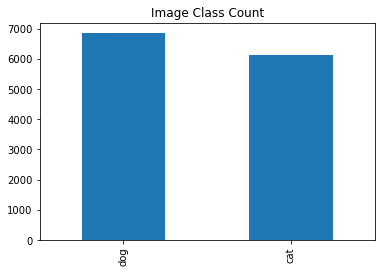

In [15]:
df.LabelName.value_counts().plot(kind='bar')
plt.title('Image Class Count')
plt.show()

In [16]:
df.describe()

Confidence          XMin          XMax          YMin          YMax  \
count     12966.0  12966.000000  12966.000000  12966.000000  12966.000000   
mean          1.0      0.099437      0.901750      0.088877      0.945022   
std           0.0      0.113023      0.111468      0.097345      0.081500   
min           1.0      0.000000      0.408125      0.000000      0.451389   
25%           1.0      0.000000      0.830625      0.000000      0.910000   
50%           1.0      0.061250      0.941682      0.059695      0.996875   
75%           1.0      0.167500      0.998889      0.144853      0.999062   
max           1.0      0.592500      1.000000      0.587088      1.000000   

         IsOccluded   IsTruncated     IsGroupOf   IsDepiction      IsInside  \
count  12966.000000  12966.000000  12966.000000  12966.000000  12966.000000   
mean       0.464754      0.738470      0.013651      0.045427      0.001157   
std        0.499239      0.440011      0.118019      0.209354      0.040229   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      1.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

           XClick1X      XClick2X      XClick3X      XClick4X      XClick1Y  \
count  12966.000000  12966.000000  12966.000000  12966.000000  12966.000000   
mean       0.390356      0.424582      0.494143      0.506689      0.275434   
std        0.358313      0.441751      0.405033      0.462281      0.415511   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%        0.221292      0.096875      0.285071      0.130000      0.024323   
50%        0.435625      0.415625      0.531919      0.623437      0.146319   
75%        0.609995      0.820000      0.787500      0.917529      0.561323   
max        0.999375      0.999375      1.000000      0.999375      0.999375   

           XClick2Y      XClick3Y      XClick4Y  
count  12966.000000  12966.000000  12966.000000  
mean       0.447448      0.641749      0.582910  
std        0.401580      0.448054      0.403454  
min       -1.000000     -1.000000     -1.000000  
25%        0.218333      0.405816      0.400000  
50%        0.480838      0.825000      0.646667  
75%        0.729069      0.998042      0.882500  
max        0.999375      1.000000      0.999375

## Sample of Images

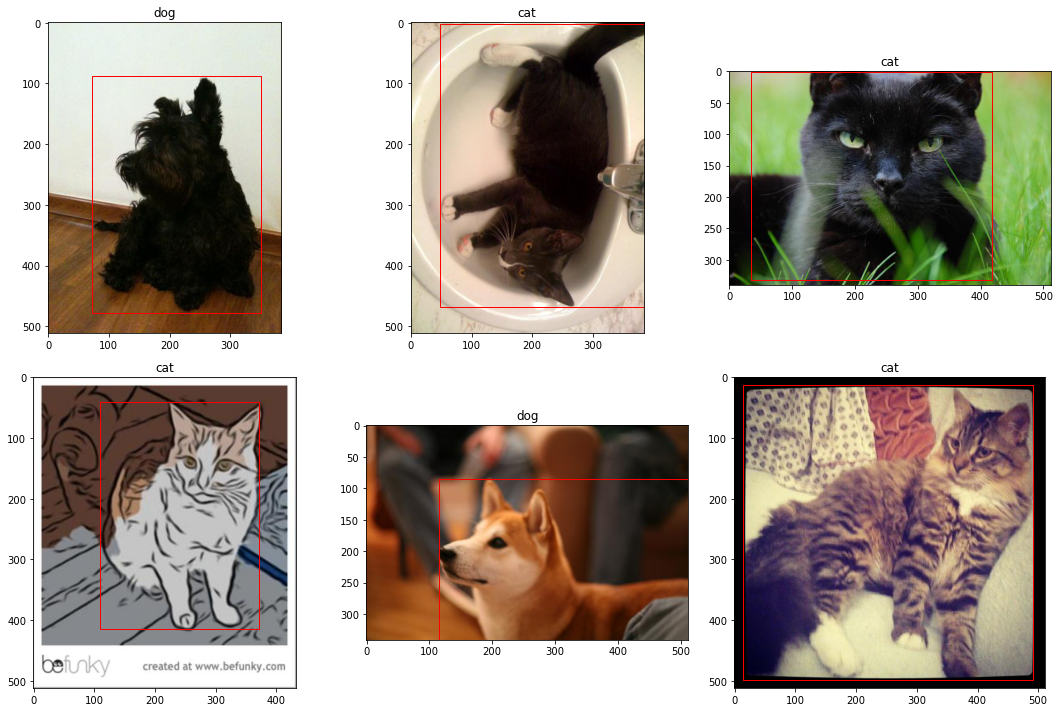

In [17]:
# plot random 6 images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(df.shape[0], size=6, replace=False)):
    img = mpimg.imread(path + df.ImageID.values[j] + '.jpg')
    h, w = img.shape[:2]
    coords = df.iloc[j,4:8]
    ax[i].imshow(img)
    ax[i].set_title(df.LabelName[j])
    ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), 
                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

### Correlation Between Features

<ipython-input-18-76ee77985b5e>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))


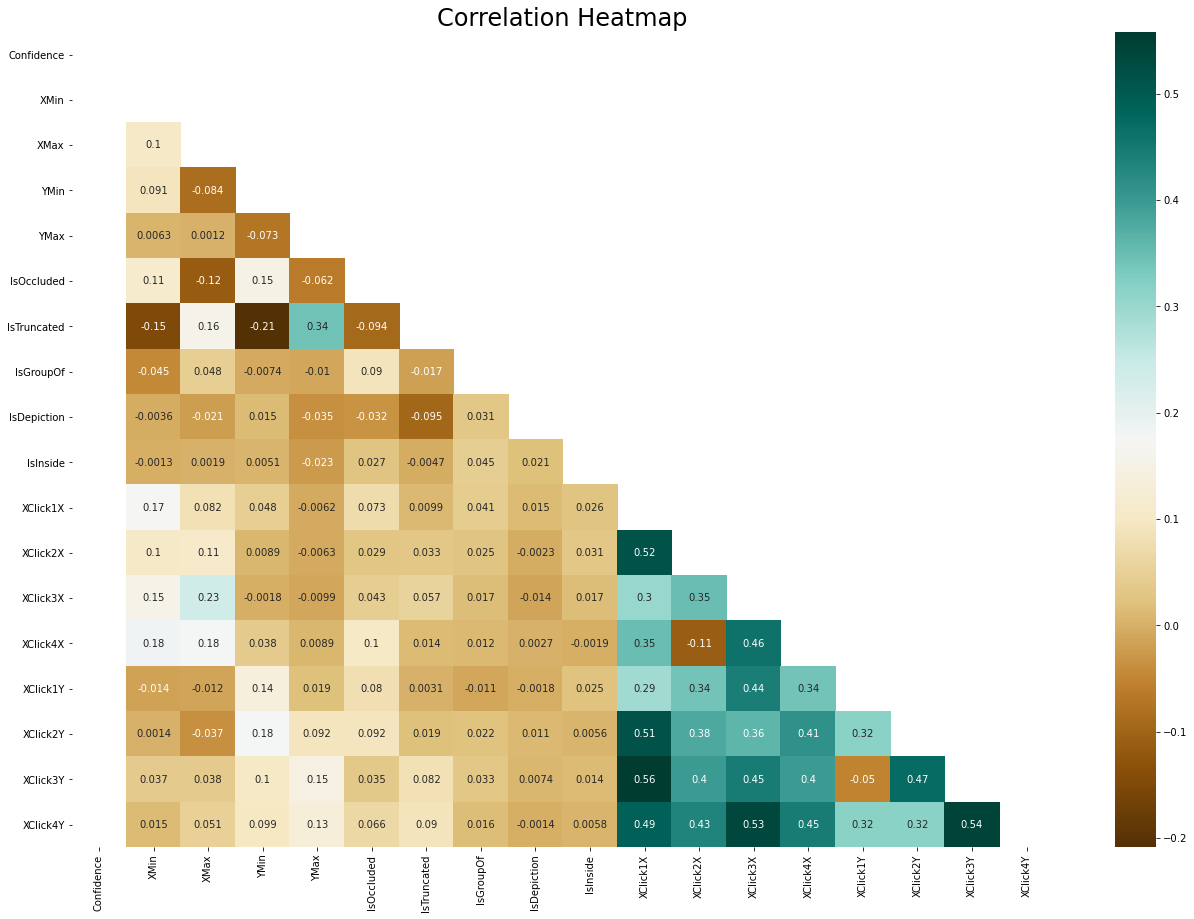

In [18]:
plt.figure(figsize=(22, 15))
corr = df.corr()
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
hm = sns.heatmap(corr, annot = True,cmap='BrBG', mask = mask)
hm.set_title('Correlation Heatmap', fontdict={'fontsize':24})
plt.show()

## Image shapes and sizes

Go through all images and record the shape of the image in pixels and the memory size

In [19]:
img_shape = []
img_size = np.zeros((df.shape[0], 1))

for i,f in enumerate(tqdm(glob.glob1(path, '*.jpg'))):
    file = path+'/'+f
    img = Image.open(file)
    img_shape.append(f"{img.size[0]}x{img.size[1]}")
    img_size[i] += os.path.getsize(file)

100%|██████████| 12966/12966 [00:01<00:00, 6659.06it/s]


Count all the different image shapes

In [20]:
img_shape_count = Counter(img_shape)


In [21]:
# create a dataframe for image shapes
img_df = pd.DataFrame(list(img_shape_count.items()), columns=['img_shape','img_count'])

In [22]:
img_df.head()

img_shape  img_count
0   512x384       3782
1   493x384          1
2   512x341       2013
3   512x381         14
4   384x473          1

There are a ton of different image shapes. Let's narrow this down by getting a sum of any image shape that has a cout less than 100 and put that in a category called `other`

In [23]:
img_df = img_df.append({'img_shape': 'other','img_count': img_df[img_df.img_count < 100].img_count.sum()}, 
                       ignore_index=True)

Drop all image shapes

In [24]:
img_df.shape

(595, 2)

In [25]:
img_df = img_df[img_df.img_count >= 100]

Check if the count sum matches the number of images

In [26]:
img_df.img_count.sum() == df.shape[0]

True

## Getting the size of each image

In [27]:
img_info = pd.DataFrame(img_shape, columns = ['Img_shape'])

In [28]:
img_info['Label'] = df.LabelName

In [29]:
img_info.head()

Img_shape Label
0   512x384   dog
1   512x384   dog
2   493x384   dog
3   512x341   dog
4   512x381   dog

In [30]:
img_info.shape

(12966, 2)

Plot

## TODO plot aspect ratio

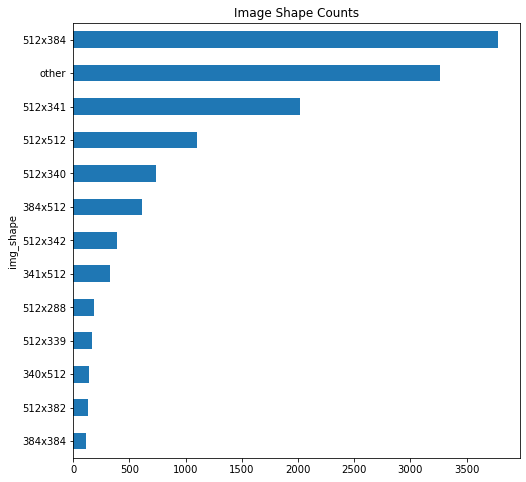

In [31]:
img_df.sort_values('img_count', inplace=True)
img_df.plot(x='img_shape', y='img_count', kind='barh', figsize=(8,8), legend=False)
plt.title('Image Shape Counts')
plt.show()

In [32]:
# convert to megabytes
img_size = img_size / 1000

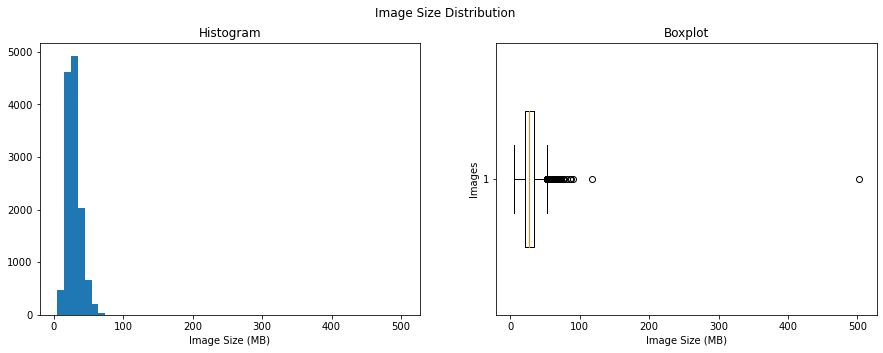

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Image Size Distribution')
ax[0].hist(img_size, bins=50)
ax[0].set_title('Histogram')
ax[0].set_xlabel('Image Size (MB)')
ax[1].boxplot(img_size, vert=False, widths=0.5)
ax[1].set_title('Boxplot')
ax[1].set_xlabel('Image Size (MB)')
ax[1].set_ylabel('Images')
plt.show()

In [34]:
dog_cnt = img_info[img_info['Label']=='dog']['Img_shape'].value_counts()
# create a dataframe for image shapes
img_df_dog = pd.DataFrame(dog_cnt)
img_df_dog = img_df_dog.reset_index()
img_df_dog.columns = ['Img_shape', 'Count']
img_df_dog.shape

(492, 2)

In [35]:
img_df_dog = img_df_dog.append({'Img_shape': 'other','Count': img_df_dog[img_df_dog.Count < 100].Count.sum()}, 
                       ignore_index=True)
img_df_dog = img_df_dog[img_df_dog.Count >= 100]
img_df_dog.shape

(8, 2)

In [36]:
cat_cnt = img_info[img_info['Label']=='cat']['Img_shape'].value_counts()
# create a dataframe for image shapes
img_df_cat = pd.DataFrame(cat_cnt)
img_df_cat = img_df_cat.reset_index()
img_df_cat.columns = ['Img_shape', 'Count']
img_df_cat.shape

(475, 2)

In [37]:
img_df_cat = img_df_cat.append({'Img_shape': 'other','Count': img_df_cat[img_df_cat.Count < 100].Count.sum()}, 
                       ignore_index=True)
img_df_cat = img_df_cat[img_df_cat.Count >= 100]
img_df_cat.shape

(8, 2)

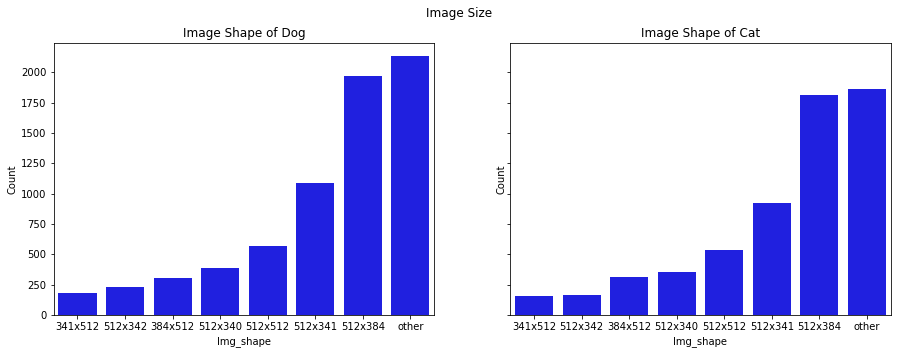

In [38]:
img_df_dog.sort_values('Count', inplace=True)

img_df_cat.sort_values('Count', inplace=True)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Image Size')

# Dog
sns.barplot(ax=axes[0], x=img_df_dog.Img_shape, y=img_df_dog.Count, color = 'blue')
axes[0].set_title('Image Shape of Dog')

# Dog
sns.barplot(ax=axes[1], x=img_df_cat.Img_shape, y=img_df_cat.Count, color = 'blue')
axes[1].set_title('Image Shape of Cat')
plt.show()

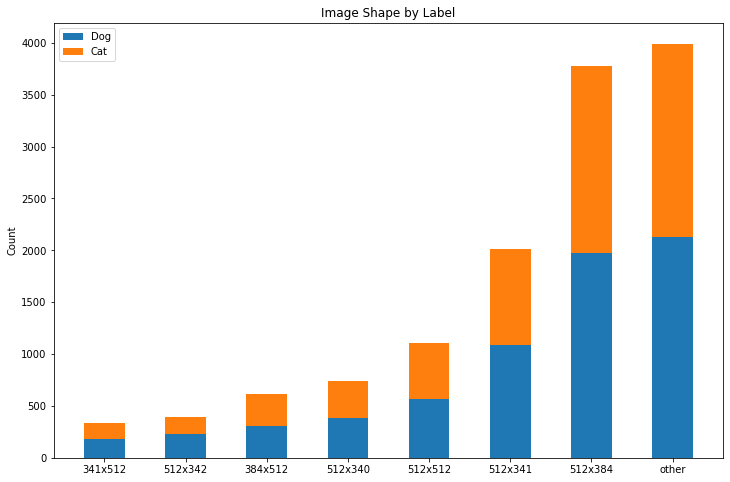

In [39]:
img_df_dog.astype({'Count':'int32'})
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.5
ax.bar(img_df_dog.Img_shape, img_df_dog.Count, width, label='Dog')
ax.bar(img_df_dog.Img_shape, img_df_cat.Count, width,bottom =  img_df_dog.Count,
       label='Cat')

ax.set_ylabel('Count')
ax.set_title('Image Shape by Label')
ax.legend()

plt.show()

# Preprocess

## Rescale the images

In [40]:
!mkdir -p images/resized

In [41]:
%%time
# resize image and save, convert to numpy

img_arr = np.zeros((df.shape[0],128*128*3)) # initialize np.array

for i, f in enumerate(tqdm(df.ImageID)):
    img = Image.open(path+f+'.jpg')
    img_resized = img.resize((128,128))
    img_resized.save("images/resized/"+f+'.jpg', "JPEG", optimize=True)
    img_arr[i] = np.asarray(img_resized, dtype=np.uint8).flatten()

100%|██████████| 12966/12966 [00:54<00:00, 239.11it/s]

CPU times: user 46 s, sys: 3.13 s, total: 49.1 s
Wall time: 54.2 s


Plot the resized and filtered images

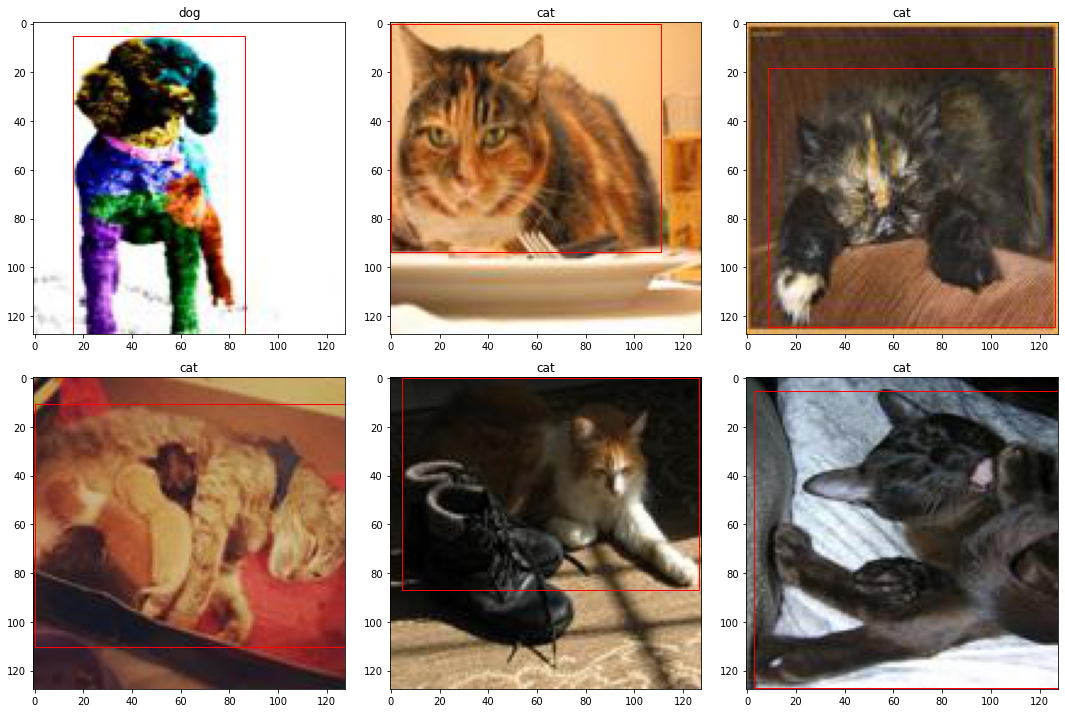

In [42]:
# plot random 6 images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(df.shape[0], size=6, replace=False)):
    img = mpimg.imread(path+'/resized/'+df.ImageID.values[j]+'.jpg')
    h, w = img.shape[:2]
    coords = df.iloc[j,4:8]
    ax[i].imshow(img)
    ax[i].set_title(df.iloc[j,2])
    ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), 
                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

In [43]:
# encode labels
df['Label'] = (df.LabelName == 'dog').astype(np.uint8)

## Checkpoint and Save data

!pip install tensorflow

!pip install --upgrade pip

In [44]:
mkdir -p data

In [45]:
np.save('data/img.npy', img_arr.astype(np.uint8))
np.save('data/y_label.npy', df.Label.values)
np.save('data/y_bbox.npy', df[['XMin', 'YMin', 'XMax', 'YMax']].values.astype(np.float32))

# Baseline in SKLearn

## Load data

In [4]:
X = np.load('data/img.npy', allow_pickle=True)
y_label = np.load('data/y_label.npy', allow_pickle=True)
y_bbox = np.load('data/y_bbox.npy', allow_pickle=True)

In [5]:
idx_to_label = {1:'dog', 0:'cat'} # encoder

Double check that it loaded correctly

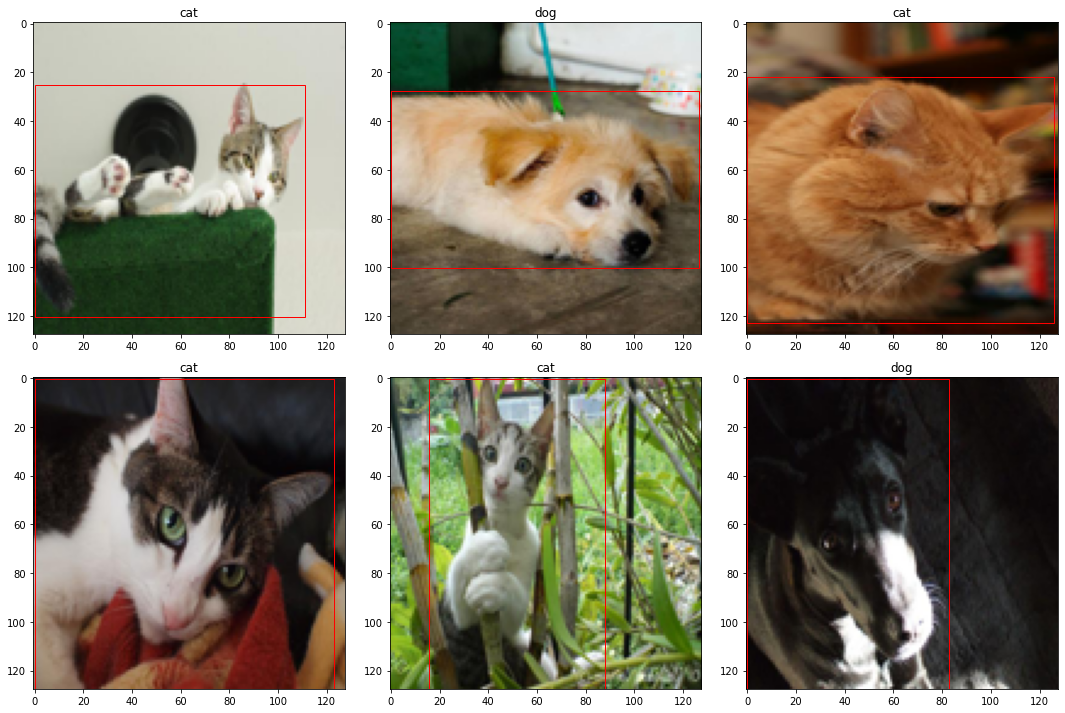

In [48]:
# plot random 6 images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(X.shape[0], size=6, replace=False)):
    coords = y_bbox[j] * 128
    ax[i].imshow(X[j].reshape(128,128,3))
    ax[i].set_title(idx_to_label[y_label[j]])
    ax[i].add_patch(plt.Rectangle((coords[0], coords[1]), 
                                  coords[2]-coords[0], coords[3]-coords[1], 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

## Classification

### Split data

Create training and testing sets

Take only a portion of the data set for training and testing purporse. We can use the entire data set later

In [49]:
import random
random.seed(10)
idxs = random.sample(range(0, X.shape[0]), 2500)
X_final = X[idxs]
y_label_final = y_label[idxs]

In [50]:
X_train, X_test, y_train, y_test_label = train_test_split(X_final, y_label_final, test_size=0.01, random_state=27)

### Train

I'm choosing `SGDClassifier` because the data is large and I want to be able to perform stochastic gradient descent and also its ability to early stop. With this many parameters, a model can easily overfit so it's important to try and find the point of where it begins to overfit and stop for optimal results.

Validation set size of 0.1

In [63]:
%%time
model = SGDClassifier(loss='log', n_jobs=-1, random_state=27, learning_rate='adaptive', eta0=1e-10, 
                      early_stopping=True, validation_fraction=0.1, n_iter_no_change=3)
# 0.2 validation TODO
model.fit(X_train, y_train)

CPU times: user 9.38 s, sys: 1.9 s, total: 11.3 s
Wall time: 2.25 s


SGDClassifier(early_stopping=True, eta0=1e-10, learning_rate='adaptive',
              loss='log', n_iter_no_change=3, n_jobs=-1, random_state=27)

In [64]:
model.n_iter_

6

Did it stop too early? Let's retrain with a few more iterations to see. Note that `SGDClassifier` has a parameter called `validation_fraction` which splits a validation set from the training data to determine when it stops.

In [51]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=27)

In [66]:
model2 = SGDClassifier(loss='log', n_jobs=-1, random_state=27, learning_rate='adaptive', eta0=1e-10)

epochs = 30

train_acc = np.zeros(epochs)
valid_acc = np.zeros(epochs)
for i in tqdm(range(epochs)):
    model2.partial_fit(X_train, y_train, np.unique(y_train))
    
    #log
    train_acc[i] += np.round(accuracy_score(y_train, model2.predict(X_train)),3)
    valid_acc[i] += np.round(accuracy_score(y_valid, model2.predict(X_valid)),3)

100%|██████████| 30/30 [00:23<00:00,  1.26it/s]


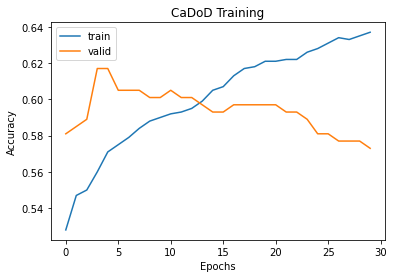

In [67]:
plt.plot(train_acc, label='train')
plt.plot(valid_acc, label='valid')
plt.title('CaDoD Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [68]:
del model2

### Evaluation

In [69]:
expLog = pd.DataFrame(columns=["exp_name", 
                               "Train Acc", 
                               "Valid Acc",
                               "Test  Acc",
                               'Train F1',
                               'valid F1',
                               'Test F1',
                               "Train MSE", 
                               "Valid MSE",
                               "Test  MSE",
                              ])

In [70]:
exp_name = f"Baseline: Linear Model with 10% validation"
expLog.loc[0,:4] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, model.predict(X_train)), 
                accuracy_score(y_valid, model.predict(X_valid)),
                accuracy_score(y_test_label, model.predict(X_test))],3))

<ipython-input-70-4c467d09feb9>:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  expLog.loc[0,:4] = [f"{exp_name}"] + list(np.round(


In [71]:
from sklearn.metrics import f1_score
expLog.loc[0,4:7] = list(np.round(
               [f1_score(y_train, model.predict(X_train)), 
                f1_score(y_valid, model.predict(X_valid)),
                f1_score(y_test_label, model.predict(X_test))],3))

<ipython-input-71-d0ff409833bc>:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  expLog.loc[0,4:7] = list(np.round(


In [72]:
expLog

exp_name Train Acc Valid Acc Test  Acc  \
0  Baseline: Linear Model with 10% validation     0.584     0.637      0.72   

  Train F1 valid F1 Test F1 Train MSE Valid MSE Test  MSE  
0    0.622    0.683   0.811       NaN       NaN       NaN

Validation set size of 0.2


In [73]:
%%time
model_2 = SGDClassifier(loss='log', n_jobs=-1, random_state=27, learning_rate='adaptive', eta0=1e-10, 
                      early_stopping=True, validation_fraction=0.2, n_iter_no_change=3)
# 0.2 validation TODO
model_2.fit(X_train, y_train)

CPU times: user 7.32 s, sys: 1.57 s, total: 8.89 s
Wall time: 1.48 s


SGDClassifier(early_stopping=True, eta0=1e-10, learning_rate='adaptive',
              loss='log', n_iter_no_change=3, n_jobs=-1, random_state=27,
              validation_fraction=0.2)

In [74]:
exp_name = f"Baseline: Linear Model with 20% validation"
expLog.loc[1,:4] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, model_2.predict(X_train)), 
                accuracy_score(y_valid, model_2.predict(X_valid)),
                accuracy_score(y_test_label, model.predict(X_test))],3))


<ipython-input-74-30a8eca74b29>:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  expLog.loc[1,:4] = [f"{exp_name}"] + list(np.round(


In [75]:
expLog.loc[1,4:7] = list(np.round(
               [f1_score(y_train, model_2.predict(X_train)), 
                f1_score(y_valid, model_2.predict(X_valid)),
                f1_score(y_test_label, model_2.predict(X_test))],3))

<ipython-input-75-82c65a38772f>:1: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  expLog.loc[1,4:7] = list(np.round(


In [76]:
expLog

exp_name Train Acc Valid Acc Test  Acc  \
0  Baseline: Linear Model with 10% validation     0.584     0.637      0.72   
1  Baseline: Linear Model with 20% validation     0.529     0.577      0.72   

  Train F1 valid F1 Test F1 Train MSE Valid MSE Test  MSE  
0    0.622    0.683   0.811       NaN       NaN       NaN  
1    0.672     0.72     0.8       NaN       NaN       NaN

Adaboost

In [97]:

clf_AB = AdaBoostClassifier(random_state=42, n_estimators=100)


In [98]:
clf_AB.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=42)

In [99]:
exp_name = f"Baseline: Adaboost"
expLog.loc[2,:4] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, clf_AB.predict(X_train)), 
                accuracy_score(y_valid, clf_AB.predict(X_valid)),
                accuracy_score(y_test_label, clf_AB.predict(X_test))],3))

<ipython-input-99-3875fd55d09f>:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  expLog.loc[2,:4] = [f"{exp_name}"] + list(np.round(


In [101]:
exp_name = f"Baseline: Adaboost"
expLog.loc[2,4:7] = list(np.round(
               [f1_score(y_train, clf_AB.predict(X_train)), 
                f1_score(y_valid, clf_AB.predict(X_valid)),
                f1_score(y_test_label, clf_AB.predict(X_test))],3))

<ipython-input-101-8f50b8d565d7>:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  expLog.loc[2,4:7] = list(np.round(


In [102]:
expLog

exp_name Train Acc Valid Acc Test  Acc  \
0  Baseline: Linear Model with 10% validation     0.584     0.637      0.72   
1  Baseline: Linear Model with 20% validation     0.529     0.577      0.72   
2                          Baseline: Adaboost      0.85     0.508      0.56   

  Train F1 valid F1 Test F1 Train MSE Valid MSE Test  MSE  
0    0.622    0.683   0.811       0.0     0.021     0.018  
1    0.672     0.72     0.8       0.0     0.021     0.018  
2     0.85    0.538   0.645       NaN       NaN       NaN

Gradient Boosting

In [103]:
clf_GB = GradientBoostingClassifier(n_estimators=100) 


In [106]:
clf_GB.fit(X_train, y_train) 

GradientBoostingClassifier()

In [107]:
exp_name = f"Baseline: Gradient Boosting"
expLog.loc[3,:4] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, clf_GB.predict(X_train)), 
                accuracy_score(y_valid, clf_GB.predict(X_valid)),
                accuracy_score(y_test_label, clf_GB.predict(X_test))],3))

<ipython-input-107-741e07d7fafd>:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  expLog.loc[3,:4] = [f"{exp_name}"] + list(np.round(


In [109]:
exp_name = f"Baseline: Gradient Boosting"
expLog.loc[3,4:7] = list(np.round(
               [f1_score(y_train, clf_GB.predict(X_train)), 
                f1_score(y_valid, clf_GB.predict(X_valid)),
                f1_score(y_test_label, clf_GB.predict(X_test))],3))

<ipython-input-109-46386521b9b8>:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  expLog.loc[3,4:7] = list(np.round(


In [110]:
expLog

exp_name Train Acc Valid Acc Test  Acc  \
0  Baseline: Linear Model with 10% validation     0.584     0.637      0.72   
1  Baseline: Linear Model with 20% validation     0.529     0.577      0.72   
2                          Baseline: Adaboost      0.85     0.508      0.56   
3                 Baseline: Gradient Boosting     0.973     0.524      0.56   

  Train F1 valid F1 Test F1 Train MSE Valid MSE Test  MSE  
0    0.622    0.683   0.811       0.0     0.021     0.018  
1    0.672     0.72     0.8       0.0     0.021     0.018  
2     0.85    0.538   0.645       NaN       NaN       NaN  
3    0.973    0.535   0.667       NaN       NaN       NaN

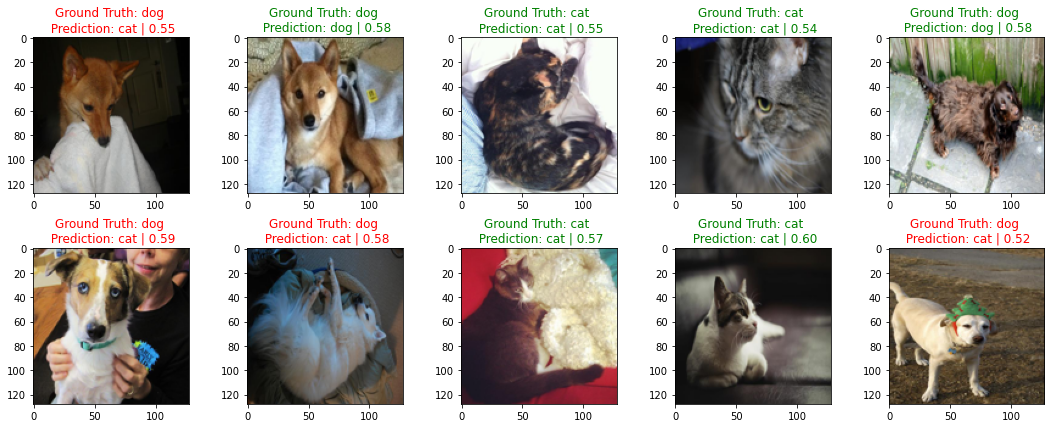

In [63]:
y_pred_label = model.predict(X_test)
y_pred_label_proba = model.predict_proba(X_test)

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=False,figsize=(15,6))
ax = ax.flatten()

for i in range(10):
    img = X_test[i].reshape(128,128,3)
    ax[i].imshow(img)
    ax[i].set_title("Ground Truth: {0} \n Prediction: {1} | {2:.2f}".format(idx_to_label[y_test_label[i]],
                                                                   idx_to_label[y_pred_label[i]],
                                                                   y_pred_label_proba[i][y_pred_label[i]]),
                   color=("green" if y_pred_label[i]==y_test_label[i] else "red"))

plt.tight_layout()
plt.show()

## Regression

### Split data

In [111]:
X_final = X[idxs]
y_bbox_final = y_bbox[idxs]

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_bbox_final, test_size=0.01, random_state=27)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=27)

### Train

In [113]:
%%time

from sklearn.linear_model import LinearRegression
# TODO closed loop solution, could use Lasso Ridge
model = LinearRegression() #fill in 
model.fit(X_train, y_train)

# might take a few minutes to train
#CPU times: user 1h 26min 40s, sys: 5min 53s, total: 1h 32min 34s
#Wall time: 17min 24s

CPU times: user 1min 20s, sys: 5.91 s, total: 1min 26s
Wall time: 14.1 s


LinearRegression()

### Evaluation

In [114]:
expLog.iloc[0,7:] = list(np.round([mean_squared_error(y_train, model.predict(X_train)), 
          mean_squared_error(y_valid, model.predict(X_valid)), 
          mean_squared_error(y_test, model.predict(X_test))],3))
expLog.iloc[1,7:] = list(np.round([mean_squared_error(y_train, model.predict(X_train)), 
          mean_squared_error(y_valid, model.predict(X_valid)), 
          mean_squared_error(y_test, model.predict(X_test))],3))
expLog.iloc[2,7:] = list(np.round([mean_squared_error(y_train, model.predict(X_train)), 
          mean_squared_error(y_valid, model.predict(X_valid)), 
          mean_squared_error(y_test, model.predict(X_test))],3))
expLog.iloc[3,7:] = list(np.round([mean_squared_error(y_train, model.predict(X_train)), 
          mean_squared_error(y_valid, model.predict(X_valid)), 
          mean_squared_error(y_test, model.predict(X_test))],3))
expLog

exp_name Train Acc Valid Acc Test  Acc  \
0  Baseline: Linear Model with 10% validation     0.584     0.637      0.72   
1  Baseline: Linear Model with 20% validation     0.529     0.577      0.72   
2                          Baseline: Adaboost      0.85     0.508      0.56   
3                 Baseline: Gradient Boosting     0.973     0.524      0.56   

  Train F1 valid F1 Test F1 Train MSE Valid MSE Test  MSE  
0    0.622    0.683   0.811       0.0     0.021     0.018  
1    0.672     0.72     0.8       0.0     0.021     0.018  
2     0.85    0.538   0.645       0.0     0.021     0.018  
3    0.973    0.535   0.667       0.0     0.021     0.018

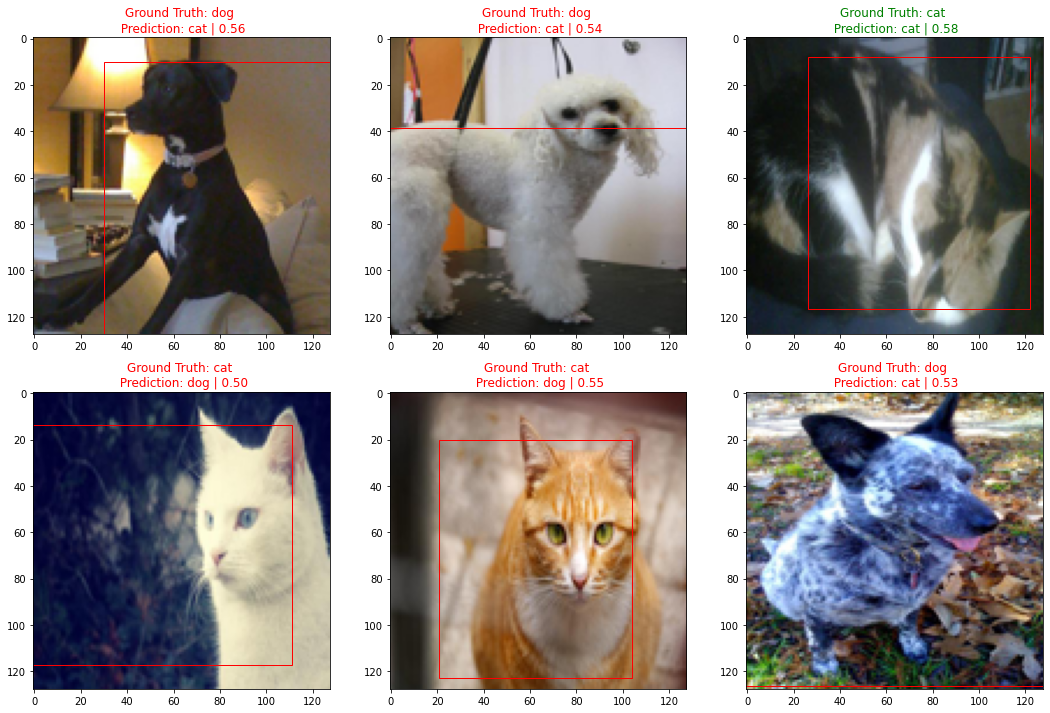

In [62]:
y_pred_bbox = model.predict(X_test)

fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(X_test.shape[0], size=6, replace=False)):
    img = X_test[j].reshape(128,128,3)
    coords = y_pred_bbox[j] * 128
    ax[i].imshow(img)
    ax[i].set_title("Ground Truth: {0} \n Prediction: {1} | {2:.2f}".format(idx_to_label[y_test_label[j]],
                                                                   idx_to_label[y_pred_label[j]],
                                                                   y_pred_label_proba[j][y_pred_label[j]]),
                   color=("green" if y_pred_label[j]==y_test_label[j] else "red"))
    ax[i].add_patch(plt.Rectangle((coords[0], coords[1]), 
                                  coords[2]-coords[0], coords[3]-coords[1], 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

# Homegrown implementation

Implement a Homegrown Logistic Regression model. Extend the loss function from CXE to CXE + MSE, i.e., make it a complex multitask loss function the resulting model   predicts the class and bounding box coordinates at the same time.

# Results / Discussion

# Conclusion